In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plot inline graphics
%pylab inline
import os.path
from shapely.geometry import Point
import geopandas as gpd
import contextily as ctx


Populating the interactive namespace from numpy and matplotlib


In [2]:
# get an Open Street Map basemap
# from https://automating-gis-processes.github.io/2018/notebooks/L6/retrieve_osm_data.html

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))
    

In [21]:
# setup run parameters
trackfile = "2019-03-30 12_11_25.csv"
trackfolder = "tracks"
analysedfolder = "analysed"
starttime = '2019-03-30 13:35:00'
finishtime = '2019-03-30 16:20:00'

# true_wind_initial = 245
# true_wind_final = 245
# wind_shift_final = true_wind_final - true_wind_initial
tacking_angle = 80
shift_angle = 30
headsail = 1
windspeed = 10

In [22]:
trackpath = os.path.join('./', trackfolder, trackfile)
df = pd.read_csv(trackpath, header=1, sep='\t', encoding='utf-16', thousands=',')
# drop the column with all NaN
df = df.dropna(axis='columns', how='all')
# infer data types
df = df.infer_objects()
# force the datetime type (not inferred for some reason...)
df['Date'] = pd.to_datetime(df['Date'])
# df.dtypes
df['Headsail'] = headsail
df['Windspeed Approx'] = windspeed

In [23]:
# derive heading and speed from lat/long as the logger app sometimes gets it wrong!
df['Longitude Radians'] = np.radians(df['Longitude'])
df['Latitude Radians'] = np.radians(df['Latitude'])

df['y'] = np.sin(df['Longitude Radians'].diff() * np.cos(df['Latitude Radians']))
df['x'] = np.cos(df['Latitude Radians'].shift(1)) \
* np.sin(df['Latitude Radians']) \
- np.sin(df['Latitude Radians'].shift(1)) \
* np.cos(df['Latitude Radians']) \
* np.cos(df['Longitude Radians'].diff())

df['Heading Calculated'] = ( np.degrees( np.arctan2(df['y'], df['x']) ) + 360 ) % 360
df['Heading Smoothed'] = df['Heading Calculated'].rolling(window=5).mean()
df['Heading ROC'] = df['Heading Calculated'].diff().rolling(window=5).mean()
df = df.drop(columns=['y', 'x'])


df['a'] = np.sin(df['Latitude Radians'].diff() / 2) \
* np.sin(df['Latitude Radians'].diff() / 2) \
+ np.cos(df['Latitude Radians'].shift(1)) \
* np.cos(df['Latitude Radians']) \
* np.sin(df['Longitude Radians'].diff() / 2) \
* np.sin(df['Longitude Radians'].diff() / 2)
df ['c'] = 2 * np.arctan2(np.sqrt(df['a']), np.sqrt(1-df['a']))
df['d'] = df['c'] * 6371.0 / 1.852
df['Speed Calculated'] = df['d'] * 60.0 * 60.0 / df['Date'].diff().astype('timedelta64[s]')
df['Speed Smoothed'] = df['Speed (kn)'].rolling(window=5).mean()
df = df.drop(columns=['a','c','d'])

# trim to actual racing period
df = df[(df['Date'] > starttime) & (df['Date'] <= finishtime)].reindex()
df.reset_index(inplace=True)

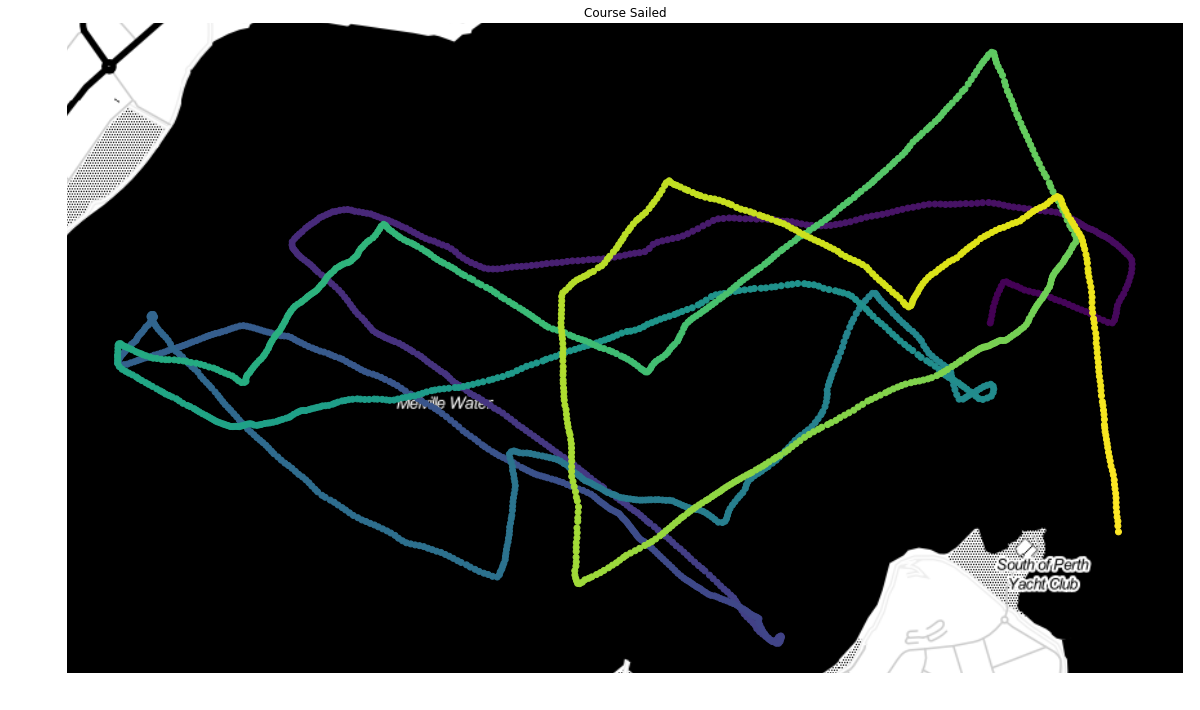

In [24]:
# plot the track - cool to hot for elapsed time

# make the lat and long into a single coords column of type POINT
df['coords'] = list(zip(df['Longitude'], df['Latitude']))
df['coords'] = df['coords'].apply(Point)

# ... turn them into geodataframe, and convert our
# epsg into 3857, since web map tiles are typically
# provided as such.
geo_df = gpd.GeoDataFrame(
    df, crs  ={'init': 'epsg:4326'},
    geometry = df['coords']
).to_crs(epsg=3857)

# ... and make the plot
ax = geo_df.plot(
    figsize= (20, 20),
    alpha  = 1,
    c=df['Date']
)
add_basemap(ax, zoom=15, url=ctx.tile_providers.ST_TONER)
ax.set_axis_off()
plt.title('Course Sailed')
plt.show()

In [82]:
# set the legs
leg = 1
df['Leg'] = 0
start = datetime.datetime.strptime('2019-03-30 13:35:00', '%Y-%m-%d %H:%M:%S')
finish = start + datetime.timedelta(minutes=4, seconds=15)
df['Leg'] = np.where(((df['Date'] >= start) & 
                      (df['Date'] <= finish)), 
                      leg, df['Leg'])

leg = 2
start = finish
finish = start + datetime.timedelta(minutes=15, seconds=50)
df['Leg'] = np.where(((df['Date'] >= start) & 
                      (df['Date'] <= finish)), 
                      leg, df['Leg'])

leg = 3
start = finish
finish = start + datetime.timedelta(minutes=13)
df['Leg'] = np.where(((df['Date'] >= start) & 
                      (df['Date'] <= finish)), 
                      leg, df['Leg'])

leg = 4
start = finish
finish = start + datetime.timedelta(minutes=18)
df['Leg'] = np.where(((df['Date'] >= start) & 
                      (df['Date'] <= finish)), 
                      leg, df['Leg'])

leg = 5
start = finish
finish = start + datetime.timedelta(minutes=28)
df['Leg'] = np.where(((df['Date'] >= start) & 
                      (df['Date'] <= finish)), 
                      leg, df['Leg'])

leg = 6
start = finish
finish = start + datetime.timedelta(minutes=19, seconds=30)
df['Leg'] = np.where(((df['Date'] >= start) & 
                      (df['Date'] <= finish)), 
                      leg, df['Leg'])

leg = 7
start = finish
finish = start + datetime.timedelta(minutes=25, seconds=32)
df['Leg'] = np.where(((df['Date'] >= start) & 
                      (df['Date'] <= finish)), 
                      leg, df['Leg'])

leg = 8
start = finish
finish = start + datetime.timedelta(minutes=3, seconds=30)
df['Leg'] = np.where(((df['Date'] >= start) & 
                      (df['Date'] <= finish)), 
                      leg, df['Leg'])

leg = 9
start = finish
finish = start + datetime.timedelta(minutes=13, seconds=20)
df['Leg'] = np.where(((df['Date'] >= start) & 
                      (df['Date'] <= finish)), 
                      leg, df['Leg'])

leg = 10
start = finish
finish = start + datetime.timedelta(minutes=5, seconds=30)
df['Leg'] = np.where(((df['Date'] >= start) & 
                      (df['Date'] <= finish)), 
                      leg, df['Leg'])

leg = 11
start = finish
finish = start + datetime.timedelta(minutes=12, seconds=15)
df['Leg'] = np.where(((df['Date'] >= start) & 
                      (df['Date'] <= finish)), 
                      leg, df['Leg'])

leg = 12
start = finish
finish = start + datetime.timedelta(minutes=8)
df['Leg'] = np.where(((df['Date'] >= start) & 
                      (df['Date'] <= finish)), 
                      leg, df['Leg'])

# leg = 13
# start = finish
# finish = start + datetime.timedelta(minutes=8)
# df['Leg'] = np.where(((df['Date'] >= start) & 
#                       (df['Date'] <= finish)), 
#                       leg, df['Leg'])

# leg = 14
# start = finish
# finish = start + datetime.timedelta(minutes=6)
# df['Leg'] = np.where(((df['Date'] >= start) & 
#                       (df['Date'] <= finish)), 
#                       leg, df['Leg'])

# plot the track - color the beats
ax = geo_df.plot(
    figsize= (20, 20),
    alpha  = 1,
    c=df['Leg']
)
add_basemap(ax, zoom=15, url=ctx.tile_providers.ST_TONER)
ax.set_axis_off()
plt.title('Course Legs')
plt.savefig('images/02_course_legs.png')
plt.show()

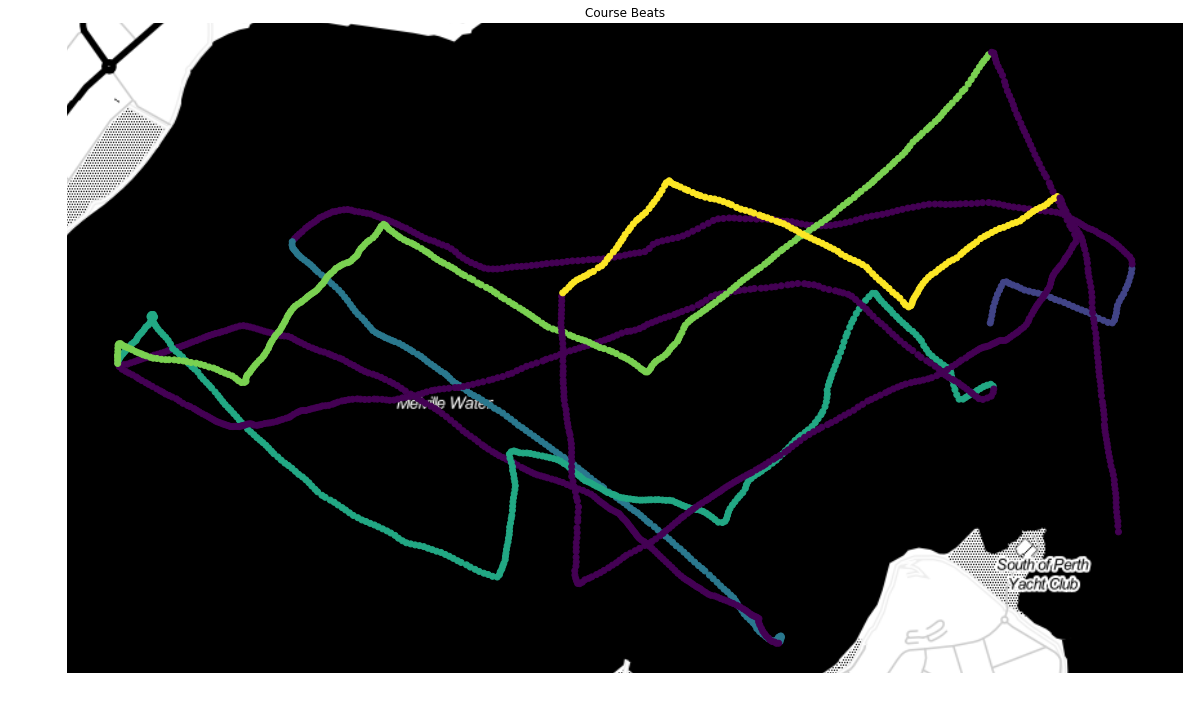

In [85]:
# set the beats
df['Beat'] = 0
#TODO: change to the below - or drop entirely and focus on VMG?
# start = datetime.datetime.strptime('2019-03-16 13:35:00', '%Y-%m-%d %H:%M:%S')
# finish = start + datetime.timedelta(minutes=38)

beat = 1
leg = 1
df['Beat'] = np.where(((df['Leg'] == leg)), 
                      beat, df['Beat'])
beat = 2
leg = 3
df['Beat'] = np.where(((df['Leg'] == leg)), 
                      beat, df['Beat'])
beat = 3
leg = 5
df['Beat'] = np.where(((df['Leg'] == leg)), 
                      beat, df['Beat'])

beat = 4
leg = 7
df['Beat'] = np.where(((df['Leg'] == leg)), 
                      beat, df['Beat'])

beat = 5
leg = 11
df['Beat'] = np.where(((df['Leg'] == leg)), 
                      beat, df['Beat'])


# plot the track - color the beats
ax = geo_df.plot(
    figsize= (20, 20),
    alpha  = 1,
    c=df['Beat']
)
add_basemap(ax, zoom=15, url=ctx.tile_providers.ST_TONER)
ax.set_axis_off()
plt.title('Course Beats')
plt.savefig('images/01_course_beats.png')
plt.show()

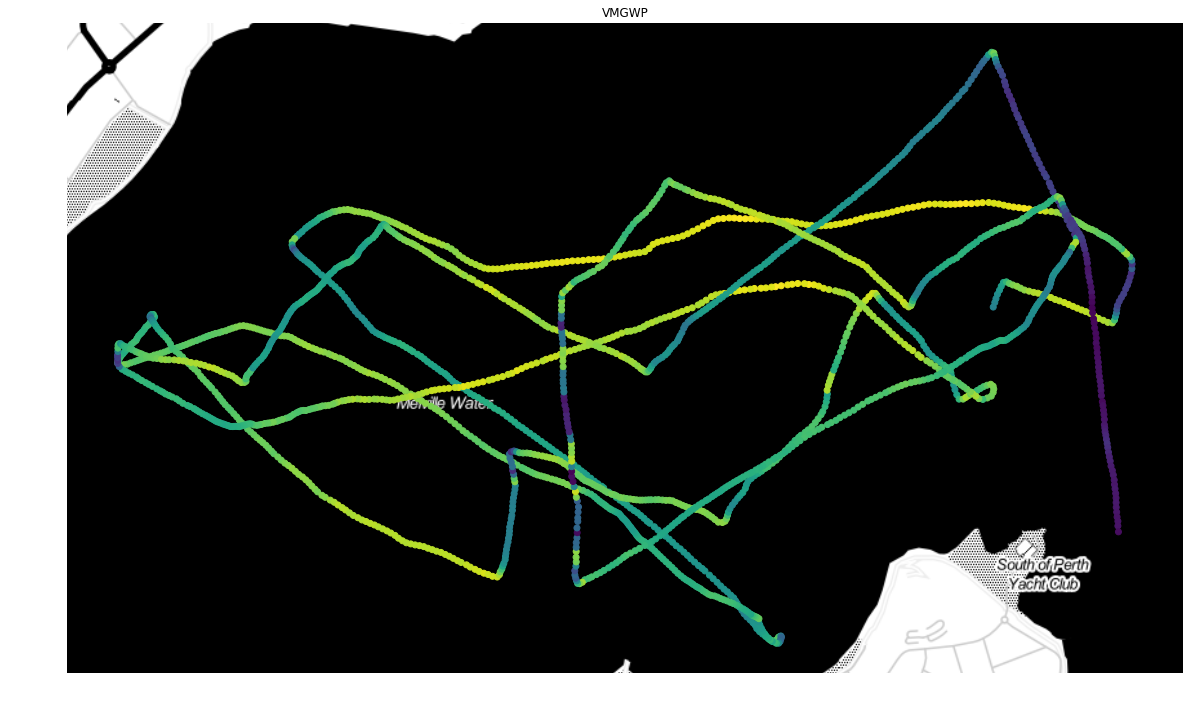

In [86]:
# Calculate BTW VMGWP for each leg

# for each leg get the lat and lon for the WP
legs = df['Leg'].unique()
for leg in legs:
    leg_mask = df['Leg'] == leg
    df.loc[leg_mask,'Lat_WP'] = df[leg_mask]['Latitude Radians'].iloc[-1]
    df.loc[leg_mask,'Lon_WP'] = df[leg_mask]['Longitude Radians'].iloc[-1]

# get the BTW
df['y'] = np.sin( (df['Lon_WP'] - df['Longitude Radians']) * np.cos(df['Latitude Radians']))
df['x'] = np.cos(df['Lat_WP']) \
    * np.sin(df['Latitude Radians']) \
    - np.sin(df['Lat_WP']) \
    * np.cos(df['Latitude Radians']) \
    * np.cos((df['Lon_WP'] - df['Longitude Radians']))

df['BTW'] = ( np.degrees( np.arctan2(df['y'], df['x']) ) + 360 ) % 360
df['BTW'] = df['BTW'].rolling(window=5).mean()
df = df.drop(columns=['y', 'x'])

# get the RBRG and VMGWP
df['RBRG'] = (df['BTW'] - df['Heading Smoothed']) % 360
df['VMGWP'] = np.cos(np.radians(df['BTW'] - df['Heading Smoothed'])) * df['Speed Smoothed']

# plot the track - color the beats
ax = geo_df.plot(
    figsize= (20, 20),
    alpha  = 1,
    c=df['VMGWP']
)
add_basemap(ax, zoom=15, url=ctx.tile_providers.ST_TONER)
ax.set_axis_off()
plt.title('VMGWP')
plt.savefig('images/03_vmgwp.png')
plt.show()

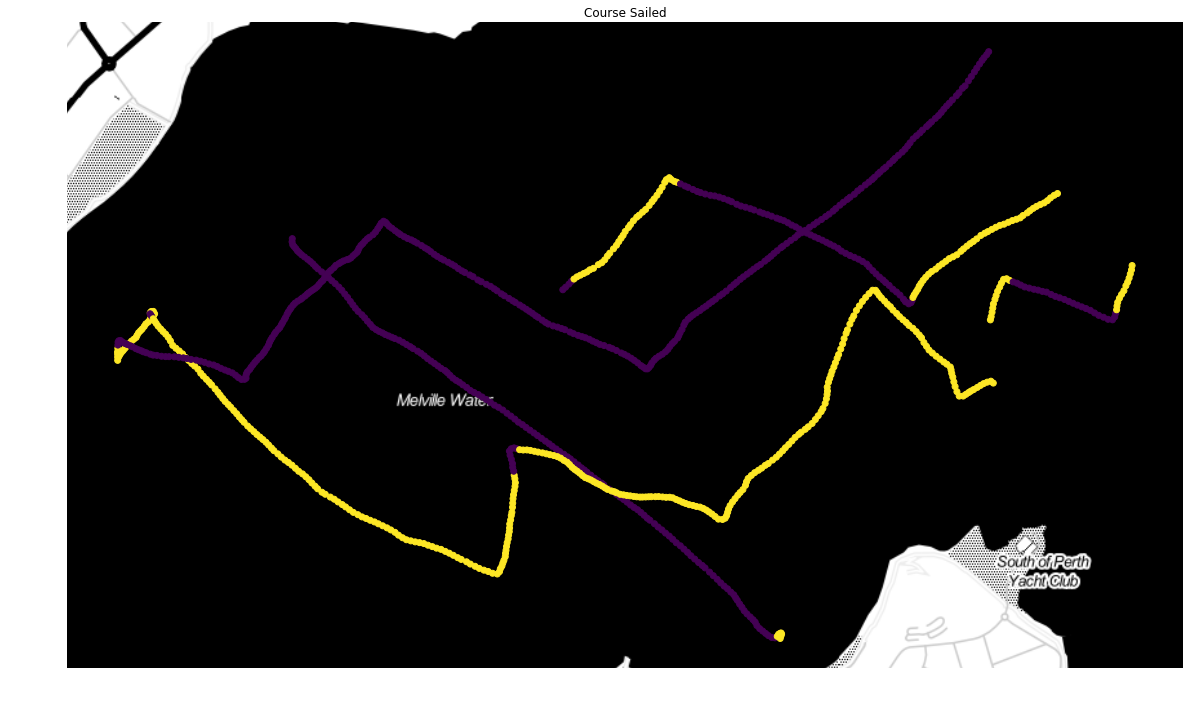

In [92]:
df['Port Tack'] = 0
df['Stbd Tack'] = 0
df['Port Tack Mean'] = np.NaN
df['Stbd Tack Mean'] = np.NaN

###################################################################################
# beat 1
beat_mask = df['Beat'] == 1
df['Binned'] = pd.cut(df[beat_mask]['Heading Smoothed'], bins=2)
tack0_mask = df['Binned'].cat.codes == 0
tack1_mask = df['Binned'].cat.codes == 1
df.drop(columns=['Binned'], inplace=True)

tack0 = df[tack0_mask]['Heading Smoothed'].mean()
tack1 = df[tack1_mask]['Heading Smoothed'].mean()

if ((tack1- tack0) % 360 > 180):
    df['Port Tack'] = np.where(tack0_mask, 1, df['Port Tack'] )
    df['Stbd Tack'] = np.where(tack1_mask, 1, df['Stbd Tack'])
    df['Port Tack Mean']=np.where(beat_mask, tack0, df['Port Tack Mean'])
    df['Stbd Tack Mean']=np.where(beat_mask, tack1, df['Stbd Tack Mean'])
else:
    df['Stbd Tack'] = np.where(tack0_mask, 1, df['Stbd Tack'])
    df['Port Tack'] = np.where(tack1_mask, 1, df['Port Tack'])
    df['Stbd Tack Mean']=np.where(beat_mask, tack0, df['Stbd Tack Mean'])
    df['Port Tack Mean']=np.where(beat_mask, tack1, df['Port Tack Mean'])

###################################################################################
#beat 2
beat_mask = df['Beat'] == 2
df['Binned'] = pd.cut(df[beat_mask]['Heading Smoothed'], bins=2)
tack0_mask = df['Binned'].cat.codes == 0
tack1_mask = df['Binned'].cat.codes == 1
df.drop(columns=['Binned'], inplace=True)

tack0 = df[tack0_mask]['Heading Smoothed'].mean()
tack1 = df[tack1_mask]['Heading Smoothed'].mean()

if ((tack1- tack0) % 360 > 180):
    df['Port Tack'] = np.where(tack0_mask, 1, df['Port Tack'] )
    df['Stbd Tack'] = np.where(tack1_mask, 1, df['Stbd Tack'])
    df['Port Tack Mean']=np.where(beat_mask, tack0, df['Port Tack Mean'])
    df['Stbd Tack Mean']=np.where(beat_mask, tack1, df['Stbd Tack Mean'])
else:
    df['Stbd Tack'] = np.where(tack0_mask, 1, df['Stbd Tack'])
    df['Port Tack'] = np.where(tack1_mask, 1, df['Port Tack']) 
    df['Stbd Tack Mean']=np.where(beat_mask, tack0, df['Stbd Tack Mean'])
    df['Port Tack Mean']=np.where(beat_mask, tack1, df['Port Tack Mean'])

###################################################################################
#beat 3
beat_mask = df['Beat'] == 3
df['Binned'] = pd.cut(df[beat_mask]['Heading Smoothed'], bins=2)
tack0_mask = df['Binned'].cat.codes == 0
tack1_mask = df['Binned'].cat.codes == 1
df.drop(columns=['Binned'], inplace=True)

tack0 = df[tack0_mask]['Heading Smoothed'].mean()
tack1 = df[tack1_mask]['Heading Smoothed'].mean()

if ((tack1- tack0) % 360 > 180):
    df['Port Tack'] = np.where(tack0_mask, 1, df['Port Tack'] )
    df['Stbd Tack'] = np.where(tack1_mask, 1, df['Stbd Tack'])
    df['Port Tack Mean']=np.where(beat_mask, tack0, df['Port Tack Mean'])
    df['Stbd Tack Mean']=np.where(beat_mask, tack1, df['Stbd Tack Mean'])
else:
    df['Stbd Tack'] = np.where(tack0_mask, 1, df['Stbd Tack'])
    df['Port Tack'] = np.where(tack1_mask, 1, df['Port Tack']) 
    df['Stbd Tack Mean']=np.where(beat_mask, tack0, df['Stbd Tack Mean'])
    df['Port Tack Mean']=np.where(beat_mask, tack1, df['Port Tack Mean'])
    
###################################################################################    
# beat 4
beat_mask = df['Beat'] == 4
df['Binned'] = pd.cut(df[beat_mask]['Heading Smoothed'], bins=2)
df[beat_mask].head(100)
tack0_mask = df['Binned'].cat.codes == 0
tack1_mask = df['Binned'].cat.codes == 1
df.drop(columns=['Binned'], inplace=True)

tack0 = df[tack0_mask]['Heading Smoothed'].mean()
tack1 = df[tack1_mask]['Heading Smoothed'].mean()

if ((tack1- tack0) % 360 > 180):
    df['Port Tack'] = np.where(tack0_mask, 1, df['Port Tack'] )
    df['Stbd Tack'] = np.where(tack1_mask, 1, df['Stbd Tack'])
    df['Port Tack Mean']=np.where(beat_mask, tack0, df['Port Tack Mean'])
    df['Stbd Tack Mean']=np.where(beat_mask, tack1, df['Stbd Tack Mean'])
else:
    df['Stbd Tack'] = np.where(tack0_mask, 1, df['Stbd Tack'])
    df['Port Tack'] = np.where(tack1_mask, 1, df['Port Tack']) 
    df['Stbd Tack Mean']=np.where(beat_mask, tack0, df['Stbd Tack Mean'])
    df['Port Tack Mean']=np.where(beat_mask, tack1, df['Port Tack Mean'])
    
###################################################################################    
# beat 5
beat_mask = df['Beat'] == 5
df['Binned'] = pd.cut(df[beat_mask]['Heading Smoothed'], bins=2)
df[beat_mask].head(100)
tack0_mask = df['Binned'].cat.codes == 0
tack1_mask = df['Binned'].cat.codes == 1
df.drop(columns=['Binned'], inplace=True)

tack0 = df[tack0_mask]['Heading Smoothed'].mean()
tack1 = df[tack1_mask]['Heading Smoothed'].mean()

if ((tack1- tack0) % 360 > 180):
    df['Port Tack'] = np.where(tack0_mask, 1, df['Port Tack'] )
    df['Stbd Tack'] = np.where(tack1_mask, 1, df['Stbd Tack'])
    df['Port Tack Mean']=np.where(beat_mask, tack0, df['Port Tack Mean'])
    df['Stbd Tack Mean']=np.where(beat_mask, tack1, df['Stbd Tack Mean'])
else:
    df['Stbd Tack'] = np.where(tack0_mask, 1, df['Stbd Tack'])
    df['Port Tack'] = np.where(tack1_mask, 1, df['Port Tack']) 
    df['Stbd Tack Mean']=np.where(beat_mask, tack0, df['Stbd Tack Mean'])
    df['Port Tack Mean']=np.where(beat_mask, tack1, df['Port Tack Mean'])

###################################################################################
df['Tack'] = np.NaN # Tack is 0=Port, 1=Stbd
df['Tack'] = np.where((df['Port Tack'] == 1), 0, df['Tack'])
df['Tack'] = np.where((df['Stbd Tack'] == 1), 1, df['Tack'])


# detect and correct "fake tacks" - the tack has changed but heading roc was not high enough to detect a tack
# seems as though looping is the only way to modify the dataframe row by row
for index, row in df.iterrows():
    if index == 0:
        continue
    if ( abs(df.at[index, 'Heading ROC']) < 10) & \
    (df.at[index, 'Tack'] != df.at[index-1, 'Tack']) & \
    (~pd.isnull(df.at[index, 'Tack']) & \
    (~pd.isnull(df.at[index-1, 'Tack']))):
        df.at[index, 'Tack'] = df.at[index-1, 'Tack']
        df.at[index, 'Port Tack'] = df.at[index-1, 'Port Tack']
        df.at[index, 'Stbd Tack'] = df.at[index-1, 'Stbd Tack']

# plot the track - color the beats
ax = geo_df.plot(
    figsize= (20, 20),
    alpha  = 1,
    c=df['Tack']
)
add_basemap(ax, zoom=15, url=ctx.tile_providers.ST_TONER)
ax.set_axis_off()
plt.title('Course Sailed')
plt.show()


In [93]:
df['True Wind Inferred'] = np.NaN
df['True Wind Inferred'] =  np.where((df['Port Tack'] == 1), 
                                     (df['Heading Smoothed'] - tacking_angle /2) % 360, df['True Wind Inferred'] )
df['True Wind Inferred'] =  np.where((df['Stbd Tack'] == 1), 
                                     (df['Heading Smoothed'] + tacking_angle /2) % 360, df['True Wind Inferred'] )

# df['True Wind Inferred'].fillna(value=df['True Wind Inferred'].mean(), inplace=True)
df['True Wind Inferred'].interpolate(inplace=True)
df['Apparent Wind Inferred'] = ( df['True Wind Inferred'] - df['Heading Smoothed']) % 360


In [94]:
lift_knock_window = 100

#port tack logic
df['Lift/Knock'] = np.where((df['Stbd Tack']==1), (df['Heading Smoothed'] - df['Stbd Tack Mean']) % 360, np.NaN)

# starboard tack logic
df['Lift/Knock'] = np.where((df['Port Tack']==1), (df['Port Tack Mean'] - df['Heading Smoothed']) % 360, df['Lift/Knock'])

# fix degress > 180
df['Lift/Knock'] = np.where((df['Lift/Knock']>180), df['Lift/Knock']-360, df['Lift/Knock'])


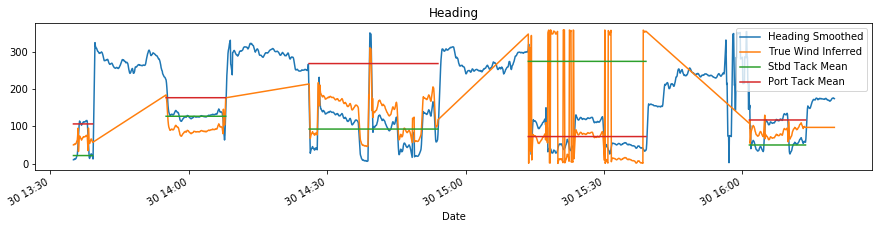

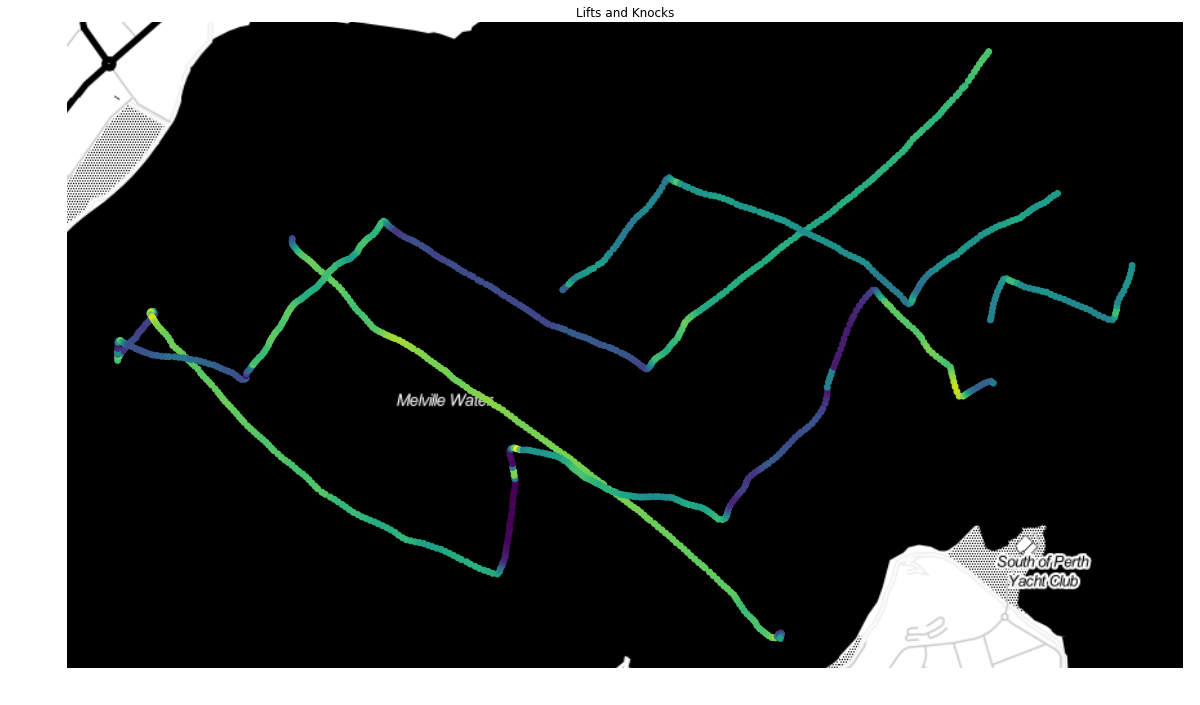

In [95]:
df.plot(x='Date', y=['Port Tack','Stbd Tack'], figsize=(15,1), color=['red','lime'], title="Tacks")
plt.savefig('images/04_tacks.png')
df.plot(x='Date', y=['Heading Smoothed', 'True Wind Inferred', 'Stbd Tack Mean', 'Port Tack Mean'], figsize=(15,3), title='Heading')
plt.savefig('images/05_heading_lift_knock.png')
ax = geo_df.plot(
    figsize= (20, 20),
    alpha  = 1,
    c=df['Lift/Knock']
)
add_basemap(ax, zoom=15, url=ctx.tile_providers.ST_TONER)
ax.set_axis_off()
plt.title('Lifts and Knocks')
plt.savefig('images/06_course_lift_knock.png')
plt.show()


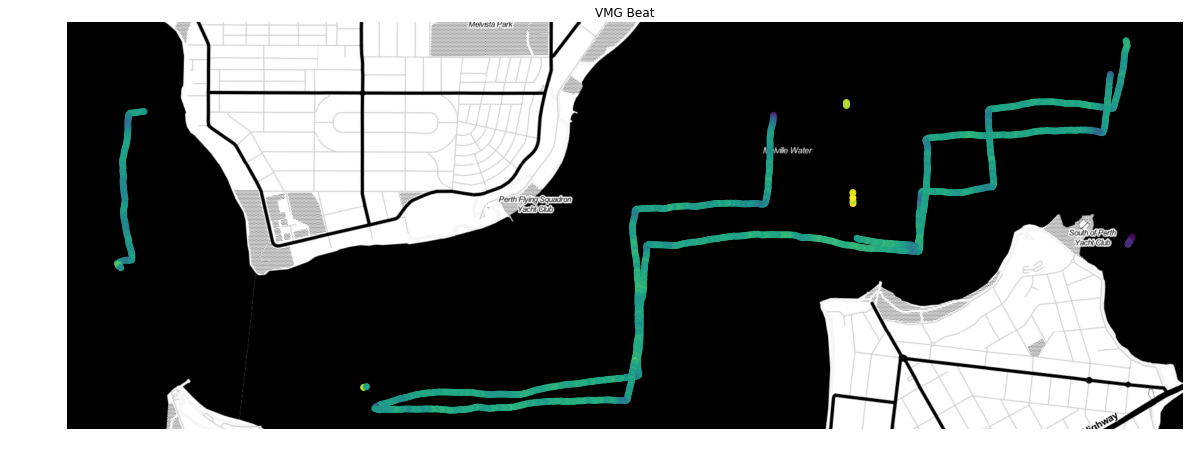

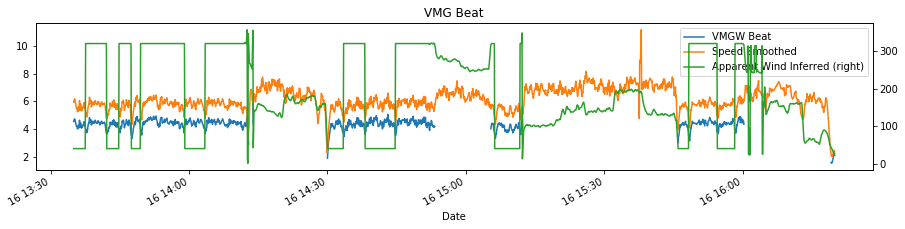

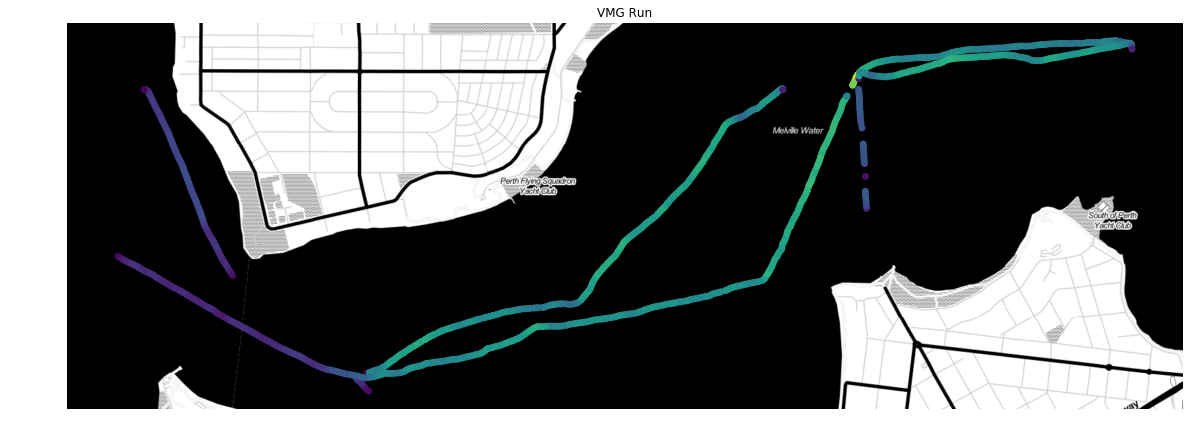

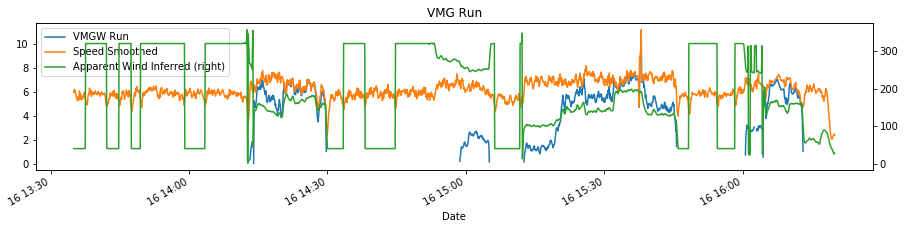

In [334]:
# VMG when beating
df['VMG Beat'] = np.NaN
beat_run_mask = (df['Apparent Wind Inferred'] <= 45) | (df['Apparent Wind Inferred'] >= 315)
                
df['VMGW Beat'] = np.where(beat_run_mask, np.abs(np.cos(np.radians(df['Apparent Wind Inferred']))) * df['Speed Smoothed'], np.NaN)
# df.plot.scatter(x='Longitude', y='Latitude', c=df['VMGW Beat'], cmap=cm.viridis, figsize=(15,10), title="VMG Beat",
#                vmin=4, vmax=5)
ax = geo_df.plot(
    figsize= (20, 20),
    alpha  = 1,
    c=df['VMGW Beat']
)
add_basemap(ax, zoom=15, url=ctx.tile_providers.ST_TONER)
ax.set_axis_off()
plt.title('VMG Beat')
plt.savefig('images/07_vmg_beat.png')
plt.show()

df.plot(x='Date', y=['VMGW Beat', 'Speed Smoothed', 'Apparent Wind Inferred'], secondary_y=['Apparent Wind Inferred'], figsize=(15,3), title='VMG Beat')

# VMG when running
df['VMG Run'] = np.NaN
beat_run_mask = (df['Apparent Wind Inferred'] >= 90) & (df['Apparent Wind Inferred'] <= 270)
                
df['VMGW Run'] = np.where(beat_run_mask, np.abs(np.cos(np.radians(df['Apparent Wind Inferred']))) * df['Speed Smoothed'], np.NaN)
# df.plot.scatter(x='Longitude', y='Latitude', c=df['VMGW Run'], cmap=cm.viridis, figsize=(15,10), title="VMG Run")
ax = geo_df.plot(
    figsize= (20, 20),
    alpha  = 1,
    c=df['VMGW Run']
)
add_basemap(ax, zoom=15, url=ctx.tile_providers.ST_TONER)
ax.set_axis_off()
plt.title('VMG Run')
plt.savefig('images/08_vmg_run.png')
plt.show()
df.plot(x='Date', y=['VMGW Run', 'Speed Smoothed', 'Apparent Wind Inferred'], secondary_y=['Apparent Wind Inferred'], figsize=(15,3), title='VMG Run')

plt.show()

In [335]:
# averages 
avg_speed_port = df[(df['Port Tack'] == 1)]['Speed (kn)'].mean()
avg_speed_stbd = df[(df['Stbd Tack'] == 1)]['Speed (kn)'].mean()

avg_angle_port = df[(df['Port Tack'] == 1)]['Apparent Wind Inferred'].mean()
avg_angle_port = 360 - avg_angle_port
avg_angle_stbd = df[(df['Stbd Tack'] == 1)]['Apparent Wind Inferred'].mean()


avg_lift_knock = df['Lift/Knock'].mean()
print("""Averages: 
    Port Tack Speed: \t{:.2f} \tAngle: {:.2f} 
    Stbd Tack Speed: \t{:.2f} \tAngle: {:.2f} 
    Lift(+)/Knock(-): \t{:.2f} deg""".format(avg_speed_port, avg_angle_port, avg_speed_stbd, avg_angle_stbd, avg_lift_knock))

Averages: 
    Port Tack Speed: 	5.77 	Angle: 40.00 
    Stbd Tack Speed: 	5.60 	Angle: 40.00 
    Lift(+)/Knock(-): 	0.00 deg


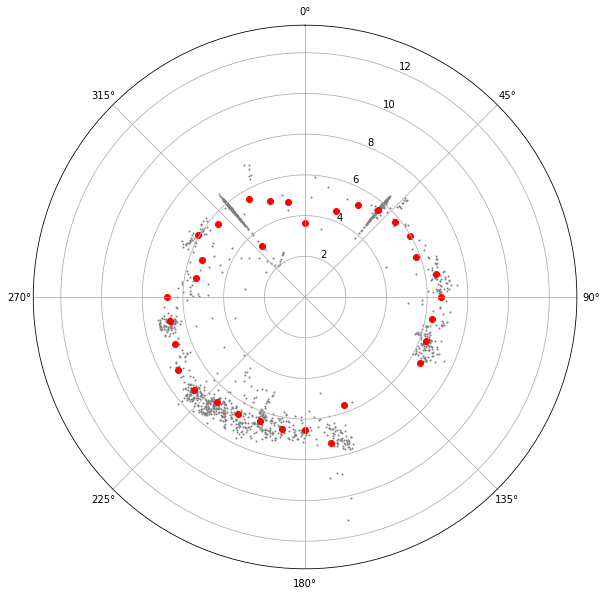

In [336]:
# plot all recorded polars
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection="polar")
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.scatter(-1 * df['Apparent Wind Inferred'] * np.pi / 180.0, df['Speed Smoothed'], color="grey", s=1)

# bin polars in 10 degree buckets and get the mean speed for each bucket
bins = list(range(0,360,10))
df2 = df.groupby(pd.cut(df['Apparent Wind Inferred'], bins))['Speed Smoothed'].mean().reset_index()
df2['theta'] = bins[:-1]
df2['theta'] = -1 * df2['theta'] * np.pi / 180.0

# plot binned means on the polar
ax.scatter(df2['theta'], df2['Speed Smoothed'], color="red")

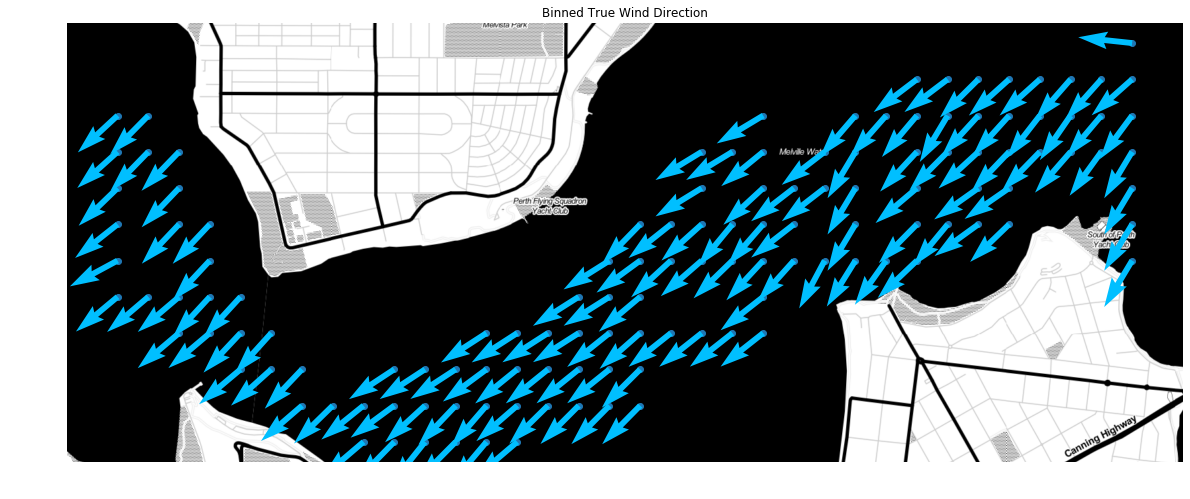

In [337]:
# bin the coordinates and plot a vector field
step = 0.002
to_bin = lambda x: np.floor(x / step) * step
df['latbin'] = df['Latitude'].map(to_bin)
df['lonbin'] = df['Longitude'].map(to_bin)
dfLocBin = df.groupby(['latbin', 'lonbin'])[['True Wind Inferred']].mean()
dfLocBin.reset_index(inplace=True)
dfLocBin['coords'] = list(zip(dfLocBin['lonbin'], dfLocBin['latbin']))
dfLocBin['coords'] = dfLocBin['coords'].apply(Point)

# ... turn them into geodataframe, and convert our
# epsg into 3857, since web map tiles are typically
# provided as such.
geo_df = gpd.GeoDataFrame(
    dfLocBin, crs  ={'init': 'epsg:4326'},
    geometry = dfLocBin['coords']
).to_crs(epsg=3857)

# ... and make the plot
ax = geo_df.plot(
    figsize= (20, 20),
    alpha  = 1
#     c=dfLocBin['True Wind Inferred']
)

geo_df['X'] = geo_df['geometry'].x
geo_df['Y'] = geo_df['geometry'].y

geo_df['U'] = np.cos(np.radians(geo_df['True Wind Inferred']))
geo_df['V'] = np.sin(np.radians(geo_df['True Wind Inferred']))

ax.quiver(geo_df['X'], 
          geo_df['Y'], 
          geo_df['U'], 
          geo_df['V'],
         color='deepskyblue')


add_basemap(ax, zoom=15, url=ctx.tile_providers.ST_TONER)

ax.set_axis_off()
plt.title('Binned True Wind Direction')
plt.show()



In [338]:
df.drop(columns=['index','Item'], inplace=True)

In [339]:
analysedfile = trackfile.replace('.csv','_analysed.csv')
analysedpath = os.path.join('./', analysedfolder, analysedfile)
df.to_csv(analysedpath, index=False)